# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # lack 2011-12
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # try 4, lack of 2011-12
# ipath= "./data/NCDC/canada/hay_rivier_a/dat.txt"
# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/manouane_est_que/dat.txt" 
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt"  # lacks inital speed
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/lac_benoit_que/dat.txt" # 似乎有速度为0的数据
# ipath= "./data/NCDC/canada/havre_st_pierre/dat.txt" # irregular sample time -> too small dataset
# ipath= "./data/NCDC/canada/moosonee_awos/dat.txt" # irregular sample time -> too small dataset
# ipath= "./data/NCDC/canada/tukialik_bay/dat.txt" # truncate, time shift
# ipath= "./data/NCDC/canada/blank_sablon/dat.txt" # truncate
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" # data may have problem

# ipath= './data/NCDC/europe/ciampino/dat.txt' # Italy
# ipath= "./data/NCDC/europe/laupheim/dat.txt"
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt"
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak, try 4
# ipath= "./data/NCDC/europe/avord/dat.txt" # double peak. try square error, 4, very good
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better
# ipath= "./data/NCDC/europe/barayas/dat.txt" # try 4, still bad fit
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer

# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # India, not very good

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt" # unable to chi square
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # sectors are 16

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # good
# ipath= "./data/NCDC/cn/luogang/dat.txt"  # good, try 4
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # 
# ipath= "./data/NCDC/cn/wusu/dat.txt" # not quite good, try 4?
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # unable to fit with chi square
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # good, but 1个方向的数据过少，很难拟合
ipath= "./data/NCDC/cn/上海/虹桥/dat.txt" # good, try 4
# ipath= "./data/NCDC/cn/上海/pudong/dat.txt"
# ipath= './data/NCDC/cn/macau/dat.txt' # not good, feels like truncate data, try 4
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= "./data/NCDC/canada/baker_lake/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/rankin_inlet/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/deer_lake_a/dat.txt" # bad dataset
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real

uipath = unicode(ipath , "utf8")

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)

In [3]:
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) ")
df.index= df['date']

In [4]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360) 
df['dir_windrose'] = df['dir']
# Convert windrose coordianates to Polar Cooridinates 
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df.describe()

,date,HrMn,dir,speed,dir_windrose
count,2.813470e+05,281347.000000,281347.00000,281347.000000,281347.000000
mean,2.001544e+07,1106.450579,181.14116,3.947066,158.748975
std,9.786473e+04,681.443079,114.82452,1.800596,107.843629
min,1.980010e+07,0.000000,0.00000,0.500000,0.000000
25%,1.993113e+07,500.000000,80.00000,3.000000,70.000000
50%,2.003082e+07,1100.000000,160.00000,4.000000,140.000000
75%,2.010111e+07,1700.000000,300.00000,5.000000,250.000000
max,2.015030e+07,2357.000000,359.00000,30.000000,350.000000


False


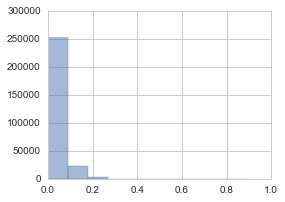

In [5]:
# Detect data stored in knot or m/s
## For data stored originally in knot, the data would cluster at 0.1 and 0.9
df['decimal'] = df.speed % 1 
df.decimal.hist(alpha=0.5, label='m/s', figsize=(4,3))
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

# Using unit in knot instead of m/s
if knot_unit:
    df['speed']=df['speed']*1.943845
    df['decimal'] = df.speed % 1 
    df.decimal.hist(alpha=0.5,label='knot')
    # need more elaboration, some is not near an integer
    df['speed']=df['speed'].apply(lambda x: int(round(x)))
    plt.legend()

print knot_unit

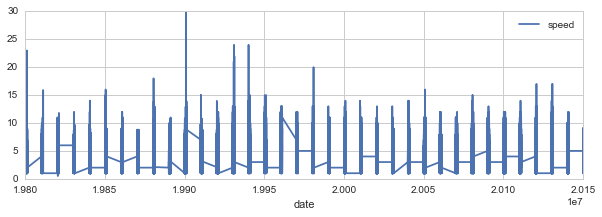

In [6]:
df['speed'].plot(legend=True,figsize=(10,3), grid=True)

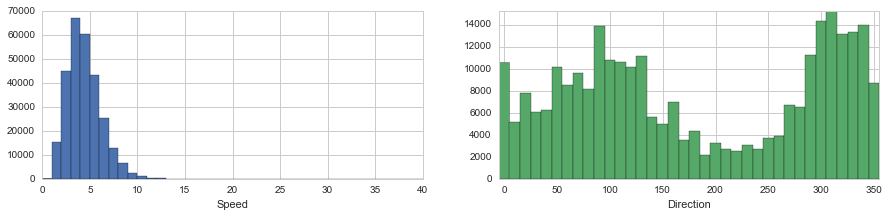

In [7]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df.speed, df.dir)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

#### 1.3.1.1 wrong direction record

In [8]:
display(df.query('dir % 10 >= 0.1'))
df = df.query('dir % 10 <= 0.1')

,date,HrMn,type,dir,speed,dir_windrose,decimal
date,,,,,,,
19940128,19940128,0,FM-15,119,3.0,331,0.0
19940718,19940718,1000,FM-15,337,5.0,113,0.0
19940805,19940805,1100,FM-15,335,9.0,115,0.0
19940810,19940810,500,FM-15,319,10.0,131,0.0
19940903,19940903,2100,FM-15,331,5.0,119,0.0
19941203,19941203,1400,FM-15,316,3.0,134,0.0
19950403,19950403,1300,FM-15,337,3.0,113,0.0
19980603,19980603,1100,FM-15,59,10.0,31,0.0
19980909,19980909,1200,FM-15,359,20.0,91,0.0


#### 1.3.1.2 sudden increase in speed

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19900917,19900917,0,SY-MT,130,30.0,320,0.0,27.9,24.9
19931012,19931012,2300,FM-16,320,24.0,130,0.0,22.0,20.0
19940127,19940127,2300,FM-16,170,24.0,280,0.0,21.0,20.0
19801008,19801008,2100,FM-12,0,23.0,90,0.0,21.0,19.0
19931221,19931221,2200,FM-15,110,22.0,340,0.0,19.0,20.0
19800714,19800714,900,FM-12,280,22.0,170,0.0,20.0,20.0
19930802,19930802,1400,FM-15,140,21.0,310,0.0,17.0,19.0
19880507,19880507,25,FM-15,170,18.0,280,0.0,11.0,8.2
20130801,20130801,730,FM-15,170,17.0,280,0.0,12.0,7.0


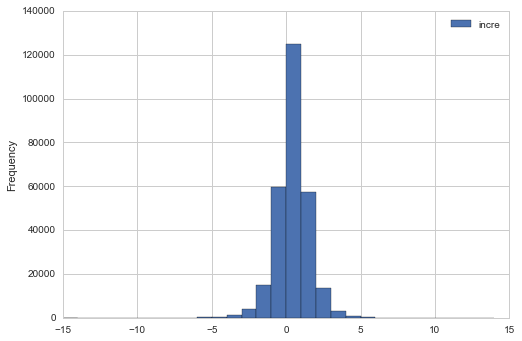

In [9]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True)

In [10]:
incre_threshold = 20 if knot_unit else 10
print len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )'))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

9


After Simple Aretefacts Handling

In [11]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
19880507,19880507,25,FM-15,170,18.0,280,0.0,11.0,8.2
20120808,20120808,530,FM-15,0,17.0,90,0.0,2.0,4.0
20130801,20130801,730,FM-15,170,17.0,280,0.0,12.0,7.0
19850430,19850430,800,FM-15,310,16.0,140,0.0,9.8,11.0
20050911,20050911,1700,FM-15,0,16.0,90,0.0,4.0,4.0
19811219,19811219,700,FM-15,140,15.9,310,0.9,7.9,3.1
19811219,19811219,500,SY-MT,140,15.9,310,0.9,7.9,7.9
19850312,19850312,900,SY-MT,0,15.0,90,0.0,9.9,10.9
19910209,19910209,600,SY-MT,200,15.0,250,0.0,10.9,9.9


#### 1.3.1.3 re-distribute angle, for un-evenly sectored data
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [12]:
df['dir'].value_counts().sort_index()

0      10555
10      5130
20      7804
30      6064
40      6251
50     10110
60      8530
70      9575
80      8128
90     13902
100    10757
110    10636
120    10161
130    11167
140     5624
150     4938
160     6934
170     3546
180     4387
190     2173
200     3221
210     2703
220     2529
230     3030
240     2716
250     3684
260     3877
270     6740
280     6489
290    11213
300    14350
310    15205
320    13146
330    13326
340    13999
350     8728
Name: dir, dtype: int64

In [13]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

36 10.0


### 1.3.2 Sampling Type Selection

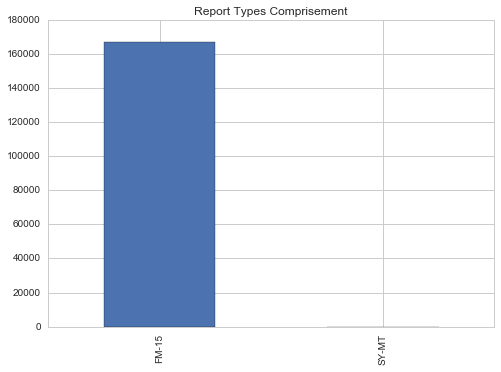

In [14]:
df.query('date > 20000000')['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query('date > 20000000')['type'].value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.3.3 Sampling Time Selection

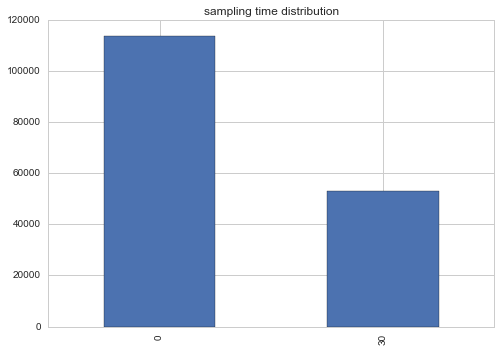

In [15]:
df['sample_time'] = df.HrMn % 100 
df.query('date > 20000000')['sample_time'].value_counts().plot(
    kind = 'bar', title = 'sampling time distribution')

sampling_time_most_used = df.query('date > 20000000')['sample_time'].value_counts().argmax()
df = df.query("sample_time==@sampling_time_most_used")
df.drop(['sample_time'], 1,inplace=True)

In [16]:
df['HrMn'].value_counts().sort_index()

0       7027
100     8319
200     8613
300     7538
400     8951
500     8956
600     7690
700     9245
800     9308
900     7970
1000    8956
1100    8634
1200    7622
1300    8263
1400    7913
1500    6972
1600    7328
1700    7150
1800    6498
1900    6973
2000    6956
2100    6562
2200    7283
2300    7508
Name: HrMn, dtype: int64

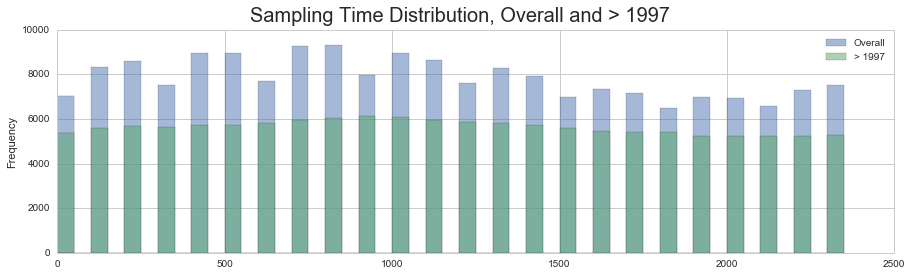

In [17]:
MID_YEAR = int(((min(df.date)+max(df.date))/2 )/10000)
# Ensure data sampled equally
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  MID_YEAR )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  MID_YEAR, fontsize = 20)
plt.legend()

### 1.3.4 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

def randomize_angle(df, sector_length = 10):
    if DIR_REDISTRIBUTE == 'even':
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2)))
    else:
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(0,sector_length)))

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5)
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 4))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

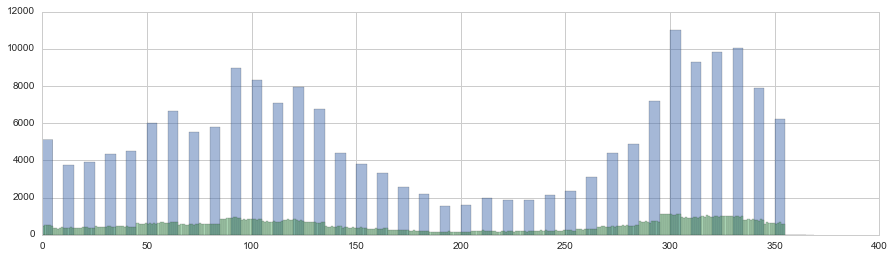

In [19]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df, SECTOR_LENGTH)

In [20]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)
    
    max_speed = df.speed.max()
    df['speed'].hist(bins=arange(0, max_speed), alpha=0.5)
    df['speed_ran'].hist(bins=arange(0, max_speed, 0.5), alpha=0.5,figsize=(15, 4))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

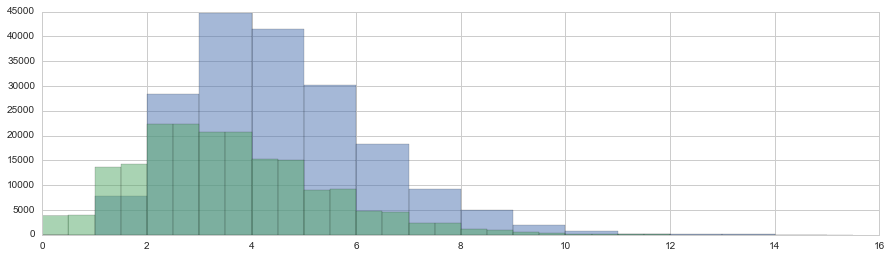

In [21]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df = randomize_speed(df)

### 1.3.5 Generate (x,y) from (speed,dir)

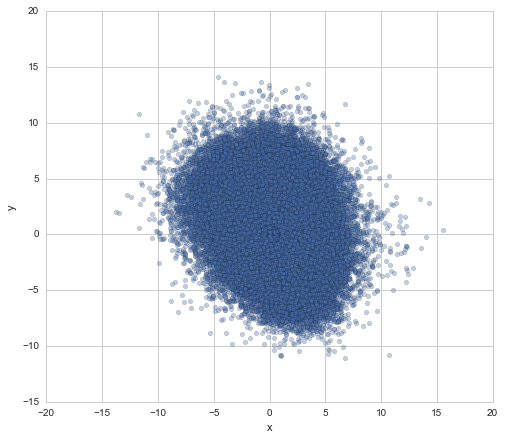

In [22]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

## 1.4 Time Shift Comparison

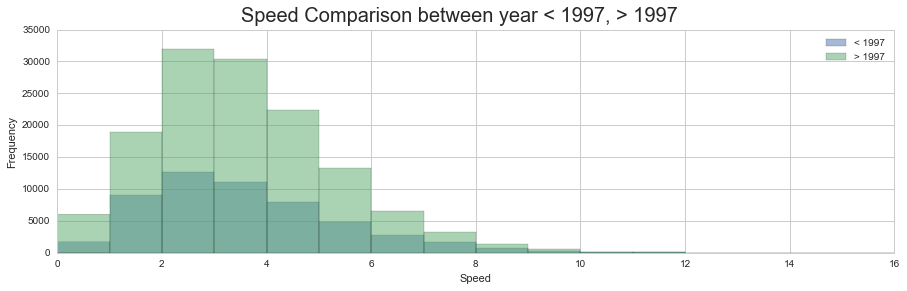

In [23]:
# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

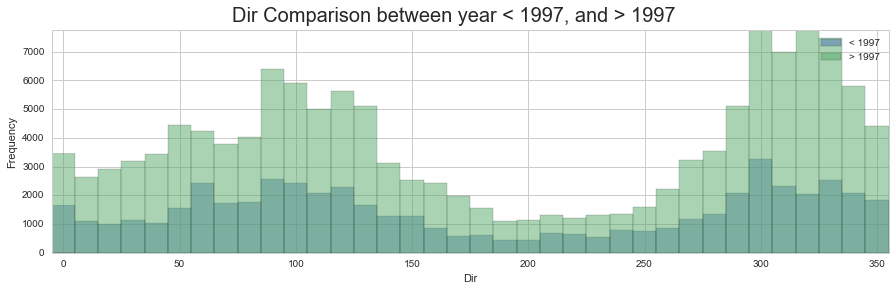

In [24]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.axis('tight')
plt.legend()

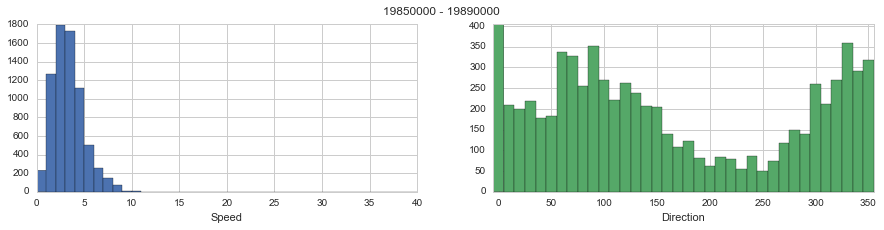

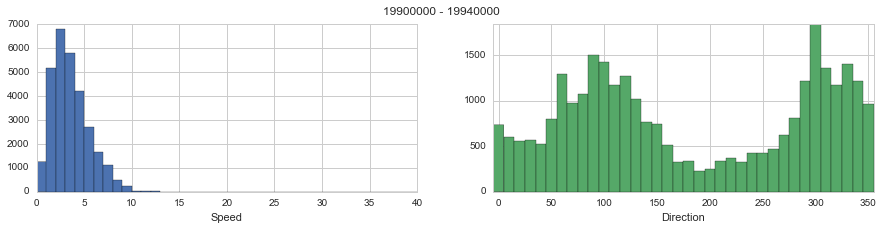

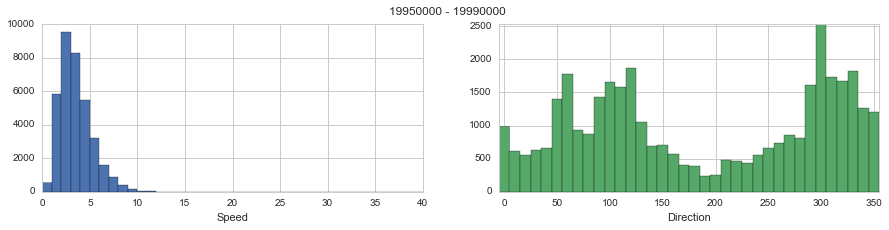

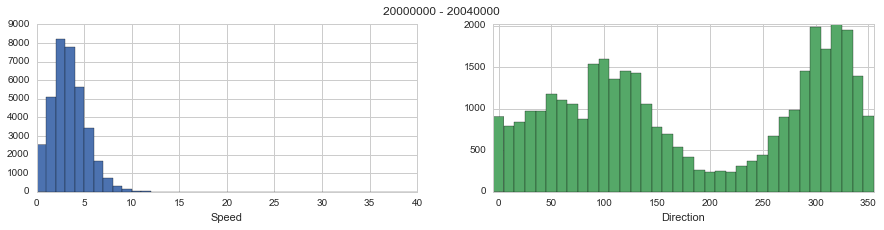

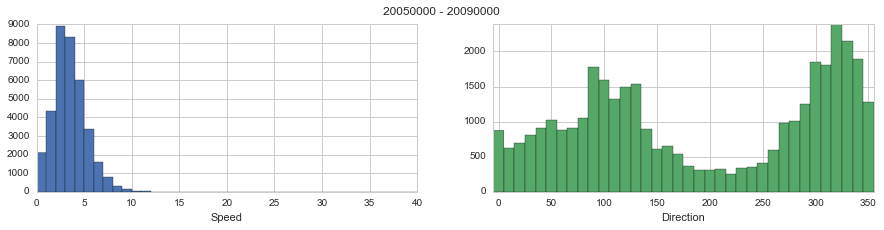

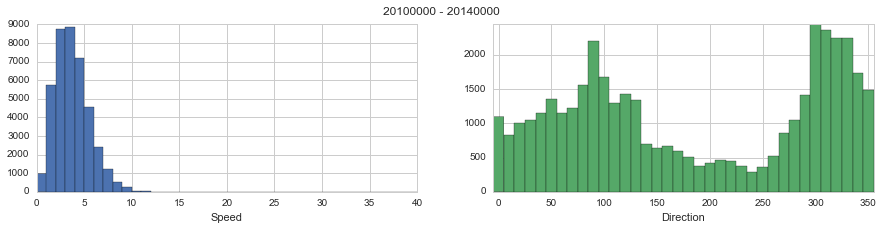

In [25]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir, title)
        
check_time_shift(df)

## 1.5 Re-select data, and overview of the clean dataset

In [26]:
## Summery of the data selection
print 'incre_threshold for artefact detect:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sampling_time_most_used

df_all_years = df
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

incre_threshold for artefact detect: 10
Report type used: FM-15
Sampling time used: 0


,date,HrMn,dir,speed,dir_windrose,decimal,incre,incre_reverse,x,y
count,4.057000e+04,40570.000000,40570.000000,40570.000000,40570.000000,40570.0,40570.000000,40570.000000,40570.000000,40570.000000
mean,2.012083e+07,1137.670693,184.912011,3.749606,152.993098,0.0,0.008578,0.008430,0.882658,0.378443
std,1.407122e+04,685.007356,115.977279,1.831878,106.550156,0.0,0.886869,0.897068,2.524834,3.180968
min,2.010010e+07,0.000000,-4.994781,0.001351,0.000000,0.0,-9.000000,-12.000000,-11.327219,-10.736111
25%,2.011041e+07,600.000000,83.086438,2.388967,70.000000,0.0,0.000000,0.000000,-0.653643,-1.899789
50%,2.012071e+07,1100.000000,163.609478,3.539369,130.000000,0.0,0.000000,0.000000,1.161686,0.105632
75%,2.013093e+07,1700.000000,304.684398,4.848241,230.000000,0.0,1.000000,1.000000,2.675887,2.717635
max,2.014123e+07,2300.000000,354.998862,14.554655,350.000000,0.0,8.000000,8.000000,14.282905,13.074373


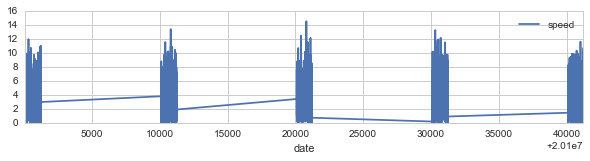

In [27]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

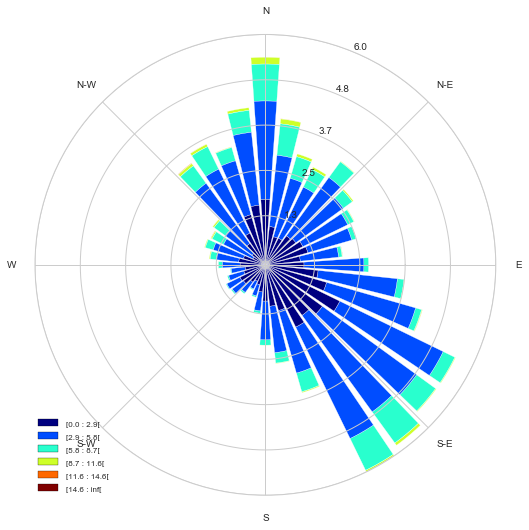

In [28]:
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

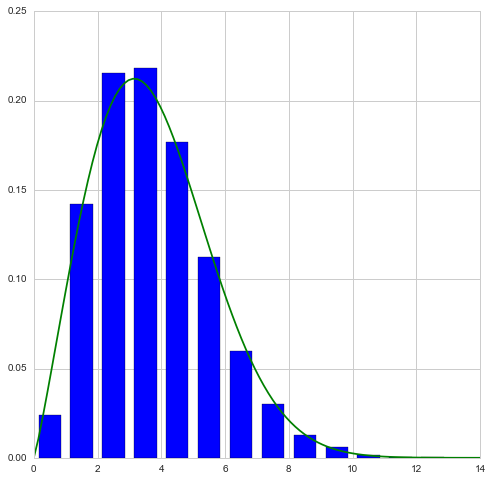

In [29]:
ax, _params = WindAxes.from_ax().pdf(df.speed, 
                                     bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

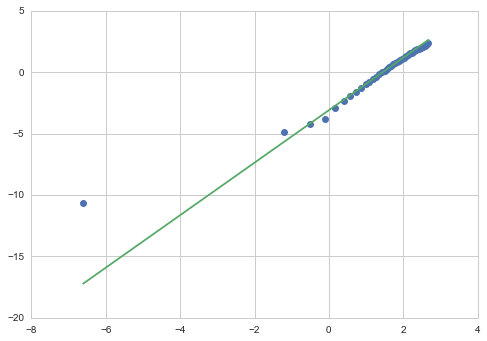

In [30]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

# 2. Create input data, i.e. speed_set

In [31]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
SPEED_SET = array(zip(df.x, df.y))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3

In [32]:
FITTING_RANGE = []
if knot_unit == True:
    fitting_axis_range = arange(-20, 21, 1)
    PLOT_AXIS_RANGE = arange(-25, 25, 1)
else:
    fitting_axis_range = arange(-10, 11, 1)
    PLOT_AXIS_RANGE = arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

# 3. Kernel Density Estimation

In [33]:
sample = SPEED_SET

In [34]:
# # The bandwidth value would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV
# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': linspace(0.5, 1.0, 7)},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# bandwidth = grid.best_params_['bandwidth']
# kde = grid.best_estimator_

In [35]:
bandwidth = 0.9 if knot_unit else 0.4
kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print bandwidth, len(kde_result)
print kde_result[:5]

0.4 441
[  2.96830620e-36   1.62948445e-34   1.72842003e-35   8.91347439e-32
   3.65205056e-21]


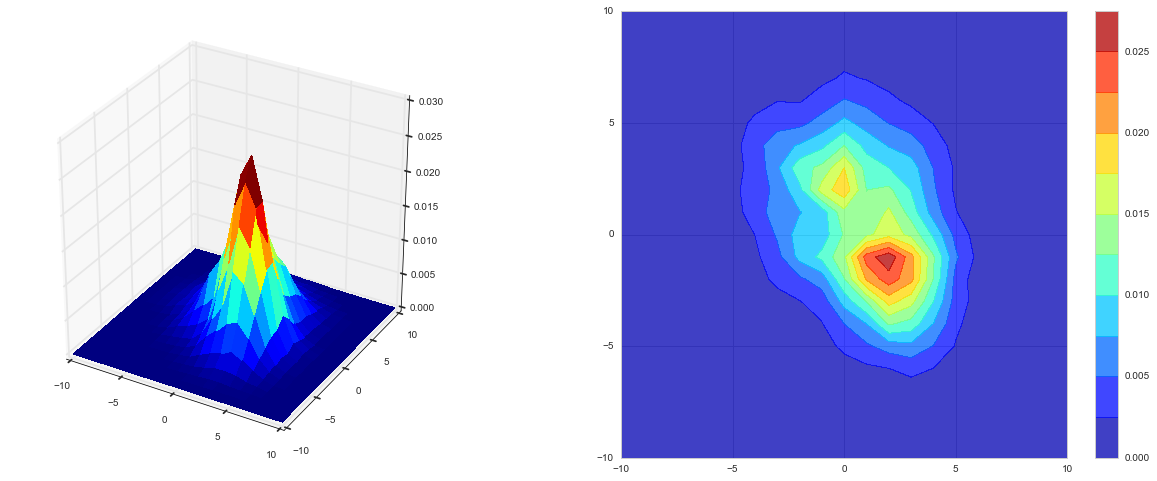

In [36]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [37]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [38]:
sample= SPEED_SET
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)

clf.converged_

True

In [39]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.409872,2.075186,-1.813001,1.657654,2.207230,-0.232194
1,0.299812,1.457530,2.537804,2.175529,2.785646,-0.211416
2,0.290316,-1.394640,1.242362,2.378803,2.760892,-0.237595


GMM Plot Result
0.409871955854 [[ 2.07518638 -1.8130015 ]] [ 1.56519174  2.27373157] -160.671120283
0.299811691579 [[ 1.45752971  2.53780438]] [ 2.06480642  2.86868068] -159.874907727
0.290316352568 [[-1.39464023  1.24236216]] [ 2.19019352  2.91277851] -151.0901776


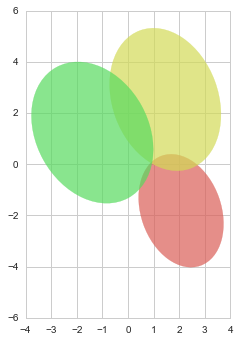

In [40]:
plot_gmm_ellipses(gmm_em_result)

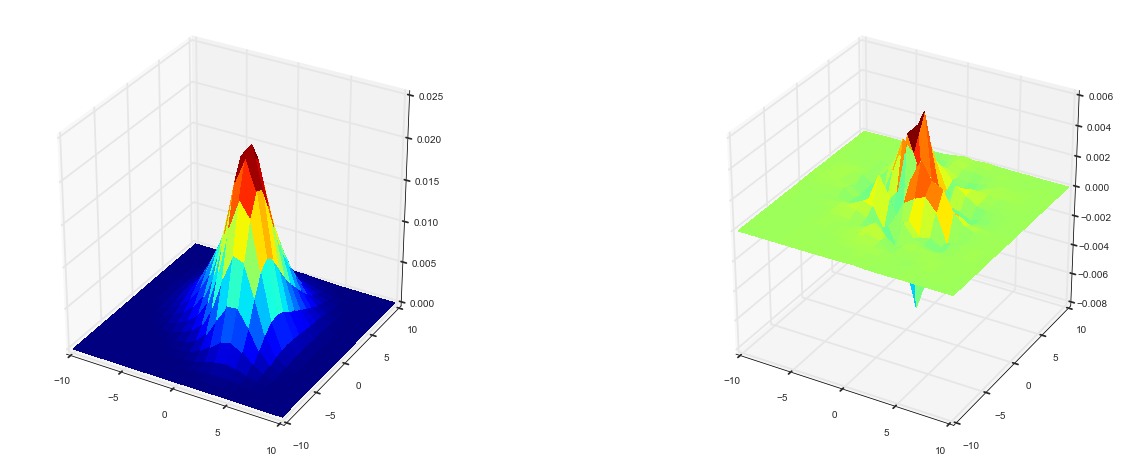

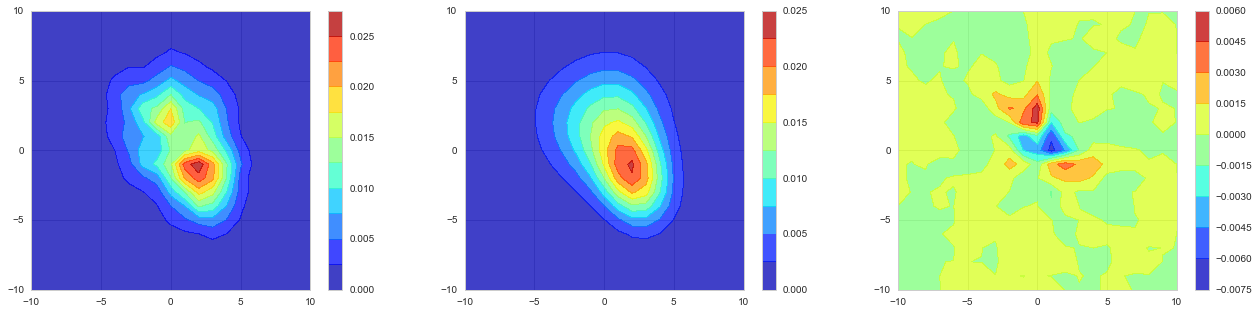

In [41]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

## GMM, EM VS. KDE

In [42]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.039357,0.021449,7.603280e-07,0.032481,0.384028,0.961641


# 5. Least Square Prob Estimation

In [43]:
sample = SPEED_SET
points = FITTING_RANGE

In [44]:
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Fit the model using different metrics
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = power(gmm_pdf_result - kde_result,2)
        result = mse_log = log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Normalized Chi square
        error_array = power(gmm_pdf_result - kde_result,2)
        result = chi_square_stat = log(sum(error_array/gmm_pdf_result))
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result)
        diff = abs(gmm_cdf - kde_cdf)
        result = KS_stat = log(np.amax(diff))
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
#     {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#     {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
FIT_METHOD = 'square_error'
result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -14.844281448694831
     jac: array([ -9.62578058e-02,  -1.19209290e-07,   0.00000000e+00,
         0.00000000e+00,   1.19209290e-07,   3.57627869e-07,
        -9.62572098e-02,   0.00000000e+00,   2.38418579e-07,
         1.19209290e-07,   2.38418579e-07,   1.19209290e-07,
        -9.62632895e-02,  -3.57627869e-07,   0.00000000e+00,
         0.00000000e+00,  -1.19209290e-07,   1.19209290e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1832
     nit: 90
    njev: 90
  status: 0
 success: True
       x: array([ 0.4007704 ,  2.23330815, -1.94235446,  1.5851784 ,  1.88824785,
       -0.05292831,  0.57738373, -0.02499895,  2.16566845,  2.71774851,
        2.78879981,  0.03663815,  0.02184587, -0.40365318,  2.4501689 ,
        0.39492635,  0.38766878,  0.09152015])

## LRMSE VS. KDE

In [45]:
kde_result[:5]

array([  2.96830620e-36,   1.62948445e-34,   1.72842003e-35,
         8.91347439e-32,   3.65205056e-21])

In [46]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.577384,-0.024999,2.165668,2.717749,2.788800,0.036638
1,0.400770,2.233308,-1.942354,1.585178,1.888248,-0.052928
2,0.021846,-0.403653,2.450169,0.394926,0.387669,0.091520


GMM Plot Result
0.577383728961 [[-0.02499895  2.16566845]] [ 2.69111573  2.81450839] 152.581736612
0.400770400076 [[ 2.23330815 -1.94235446]] [ 1.57780386  1.89441429] -171.62431258
0.0218458709631 [[-0.40365318  2.4501689 ]] [ 0.37259934  0.40917434] -50.7286748804


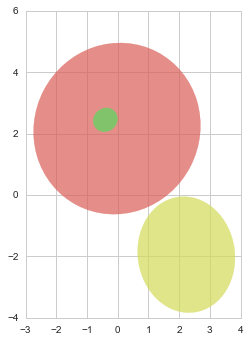

In [47]:
plot_gmm_ellipses(gmm)

## Goodness-of-fit indicators

In [48]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.049969,0.024204,3.574460e-07,0.022271,0.26331,0.981967


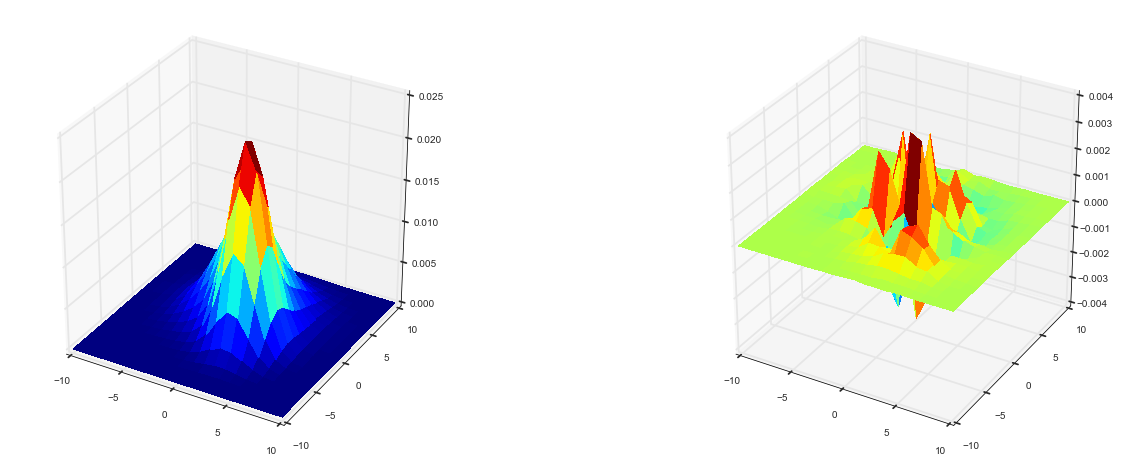

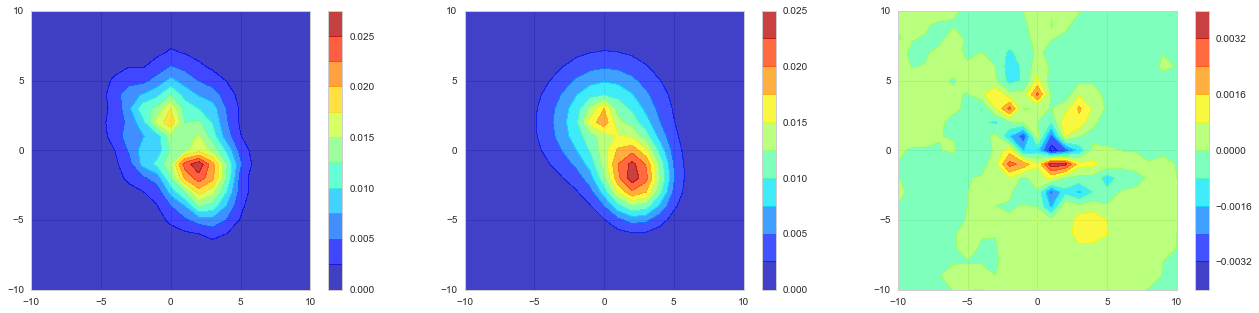

In [49]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

In [50]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

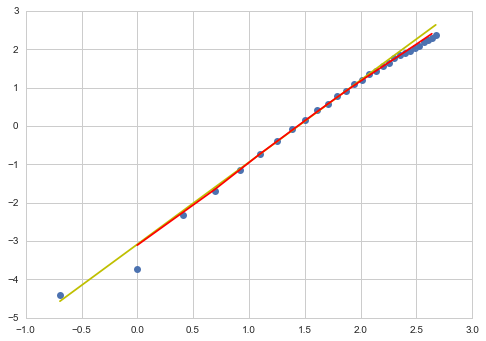

In [51]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

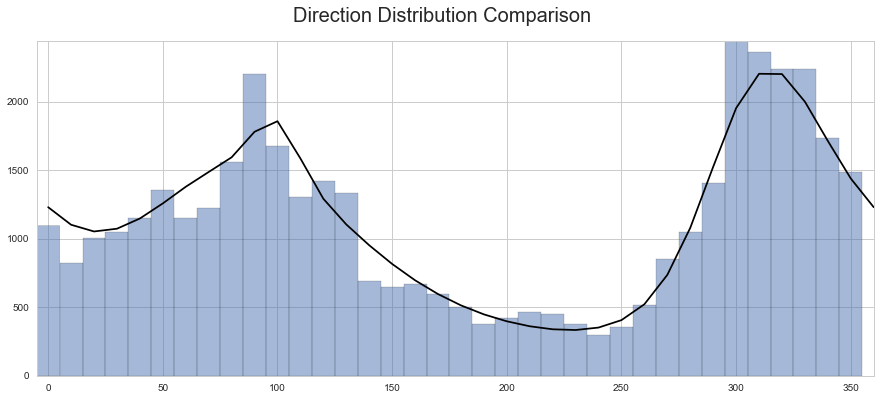

In [52]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.axis('tight')
plt.show()

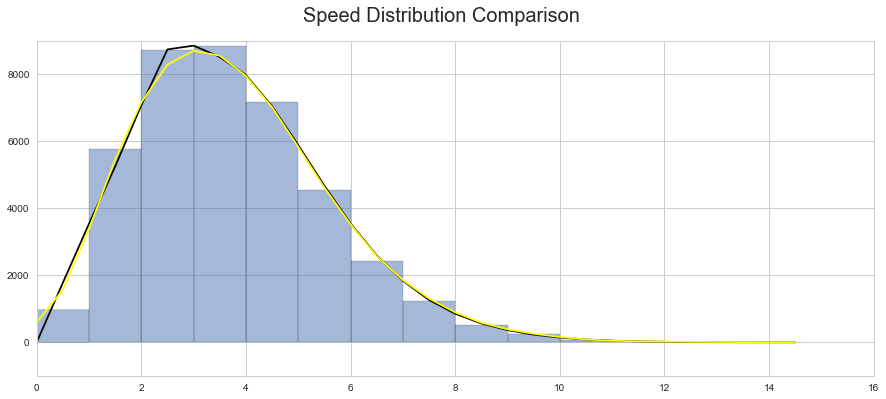

In [53]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [54]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_histogram(df.speed, 360/incre)
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count Comparison
        # 1.1. Data Histogram
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,4,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Distribution
        x_vals = arange(0, sub_max_speed, 0.2)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
        
        # 2. CDF Comaprison
        x =arange(0, sub_max_speed, 0.5)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,4,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. P-P Plot
        ax2 = fig.add_subplot(1,4,3)
        p_line = linspace(0, 1)
        plt.plot(y_gmm,y_cdf, 'o')
        plt.plot(p_line, p_line,'-')
        
        # 2.3.3. Weibull plot
        ax4 = fig.add_subplot(1,4,4)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print 'max diff:', diff.max(), ', speed value:', x[diff.argmax()], 'y gmm', y_gmm[diff.argmax()],
    return max_diff_array

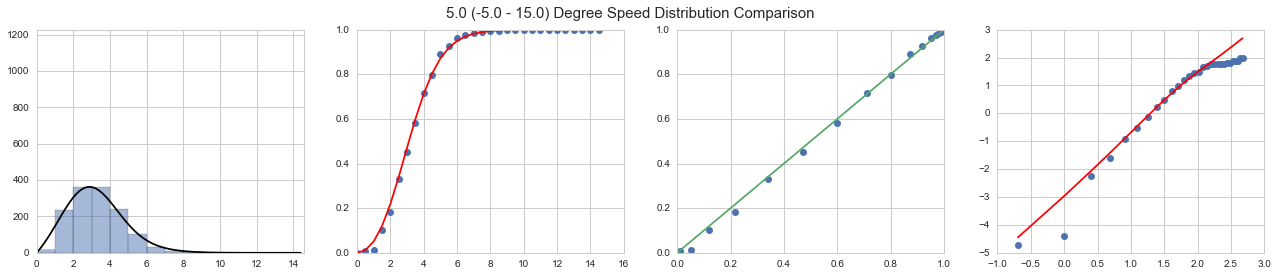

max diff: 0.0378656987874 , speed value: 1.0 y gmm 0.050247344818

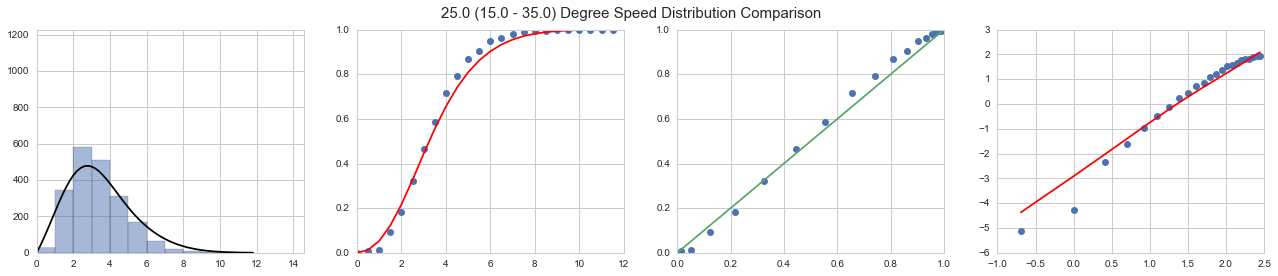

 max diff: 0.0599122516281 , speed value: 5.0 y gmm 0.808572892064

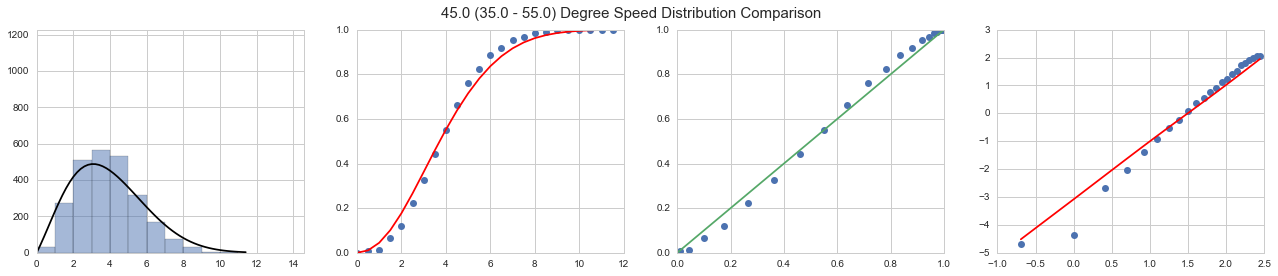

 max diff: 0.0549387418893 , speed value: 2.0 y gmm 0.177103485224

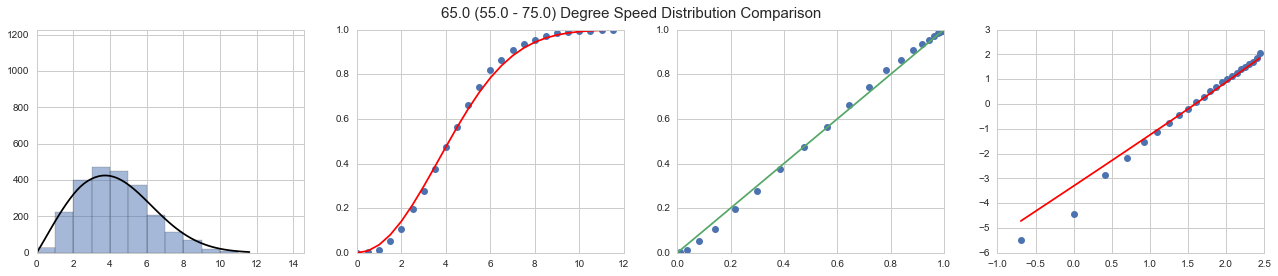

 max diff: 0.0364856549133 , speed value: 6.0 y gmm 0.7840271656

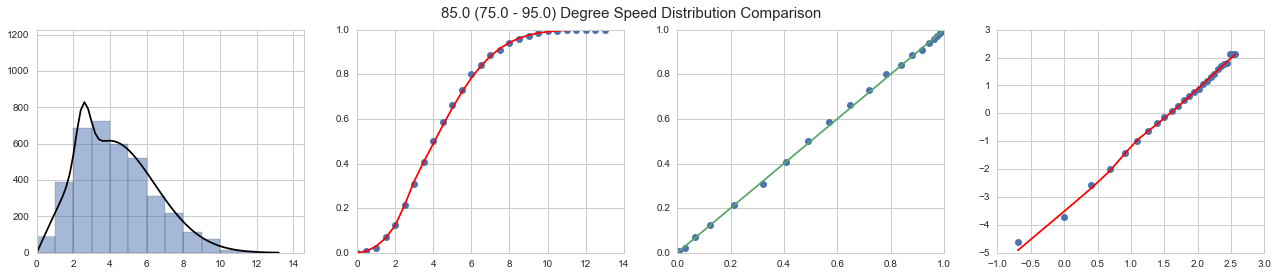

 max diff: 0.0173265439711 , speed value: 6.0 y gmm 0.783098648694

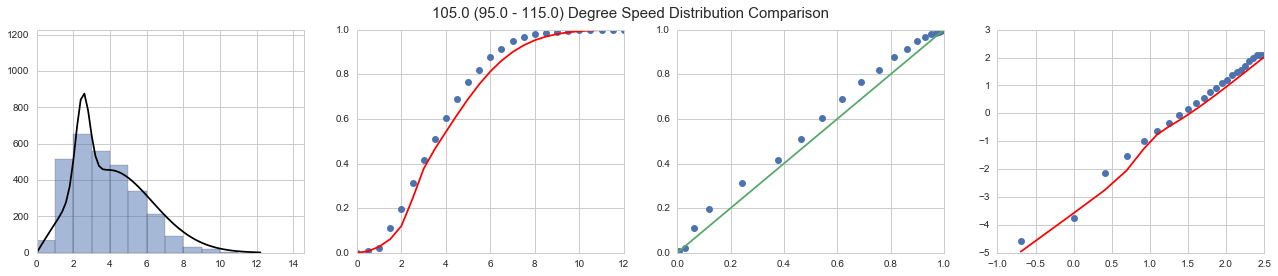

 max diff: 0.0762822070268 , speed value: 5.0 y gmm 0.689489605054

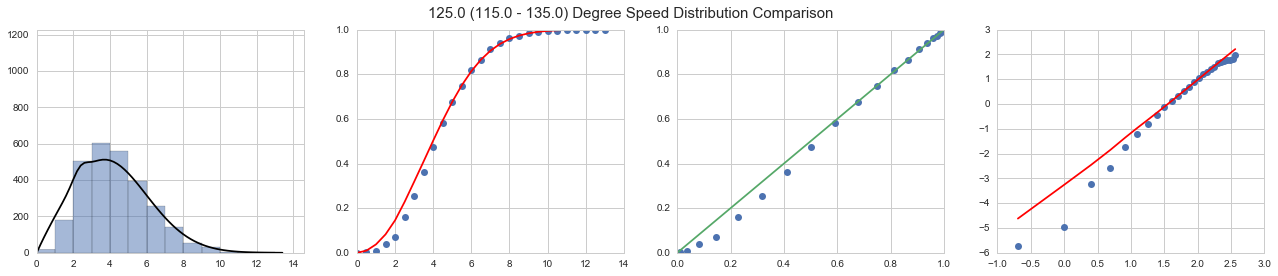

 max diff: 0.0726651433894 , speed value: 2.0 y gmm 0.145491230346

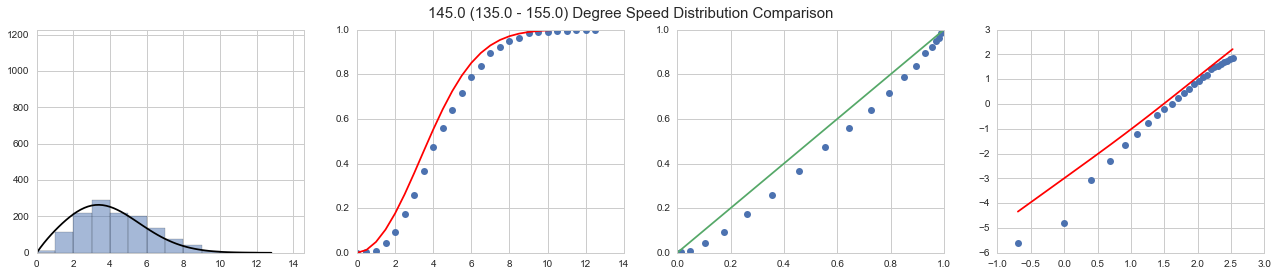

 max diff: 0.0997114194764 , speed value: 3.0 y gmm 0.356447946422

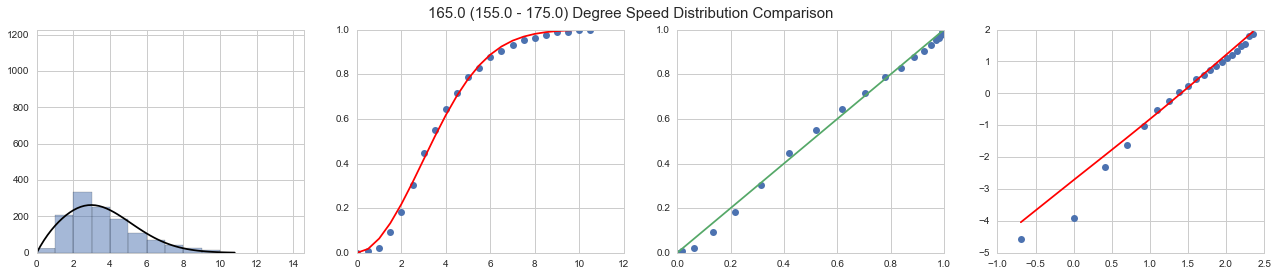

 max diff: 0.0442453722104 , speed value: 1.0 y gmm 0.0639149237446

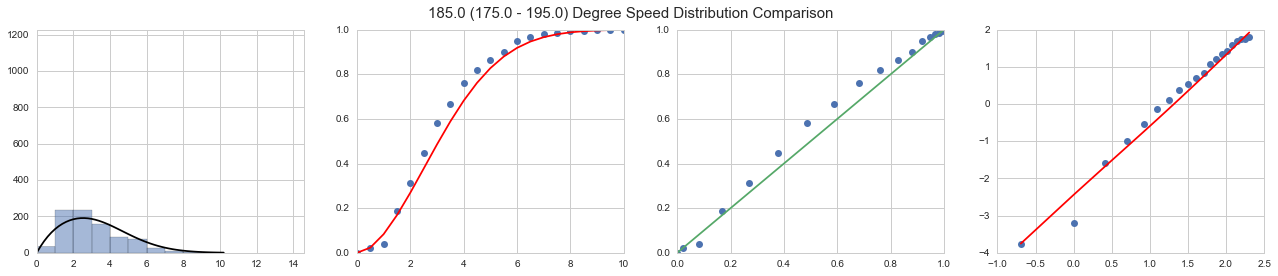

 max diff: 0.0966568805263 , speed value: 3.0 y gmm 0.485534900296

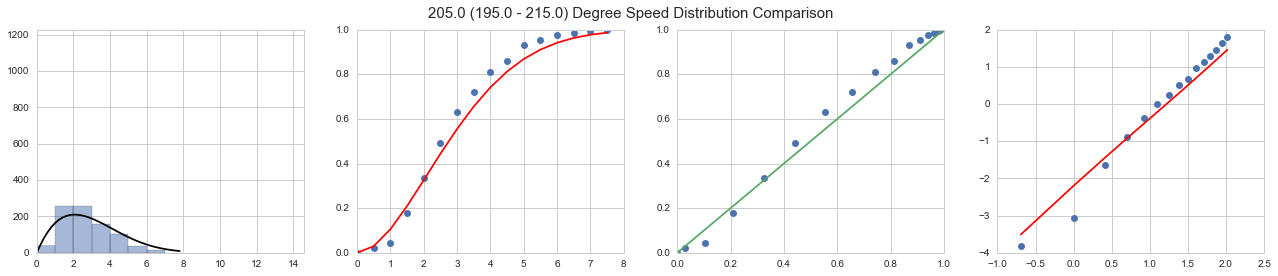

 max diff: 0.0745097877382 , speed value: 3.0 y gmm 0.554868743335

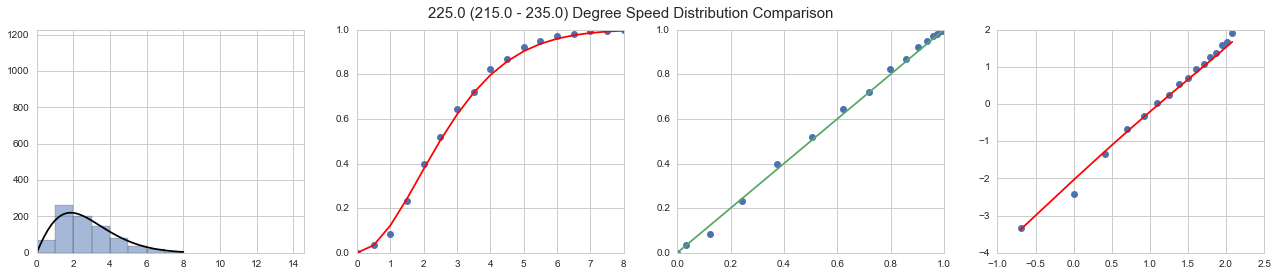

 max diff: 0.0373900125798 , speed value: 1.0 y gmm 0.121931075382

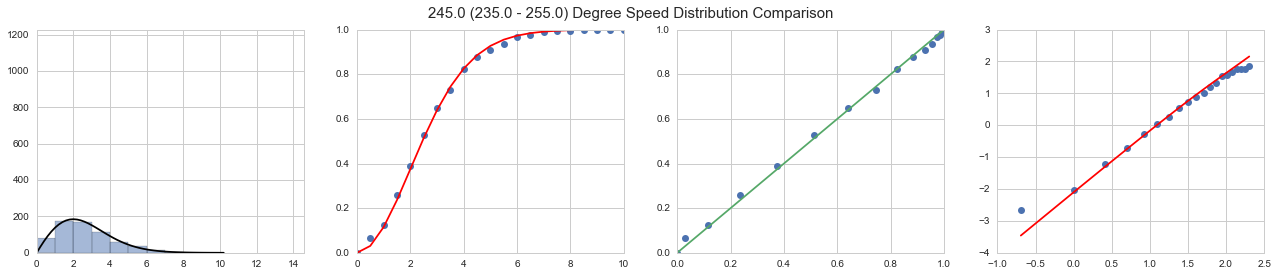

 max diff: 0.0361961005118 , speed value: 0.5 y gmm 0.0309794720073

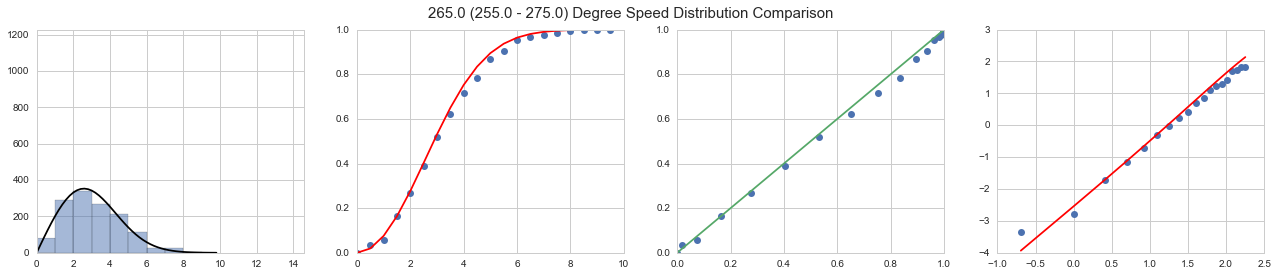

 max diff: 0.0491498505046 , speed value: 4.5 y gmm 0.833978442773

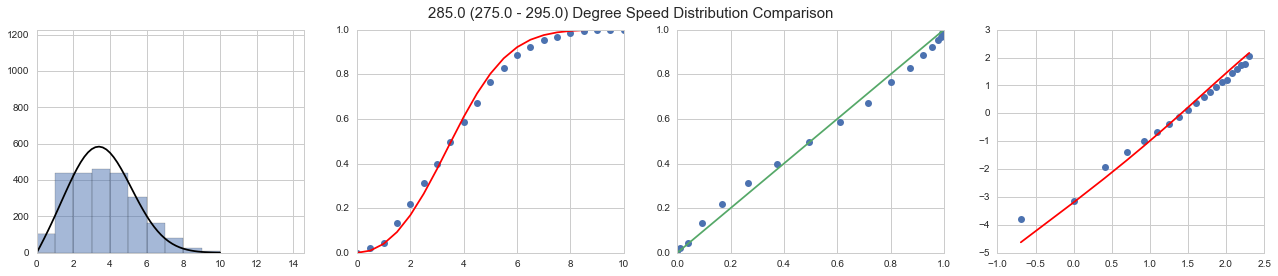

 max diff: 0.0519765398241 , speed value: 2.0 y gmm 0.168396836799

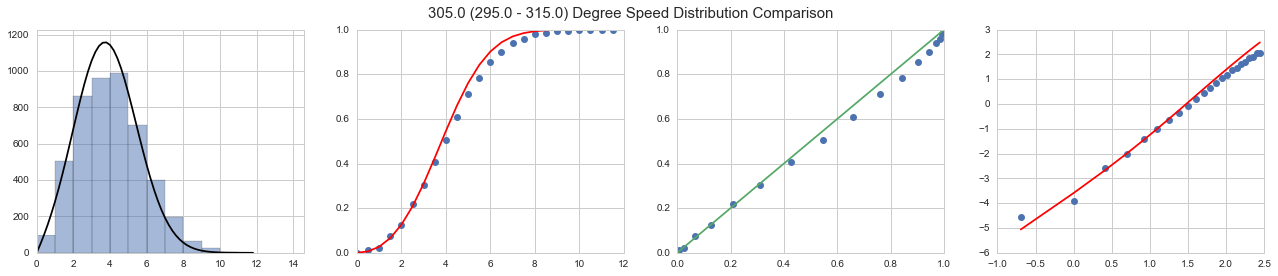

 max diff: 0.0568268132792 , speed value: 5.5 y gmm 0.841739531484

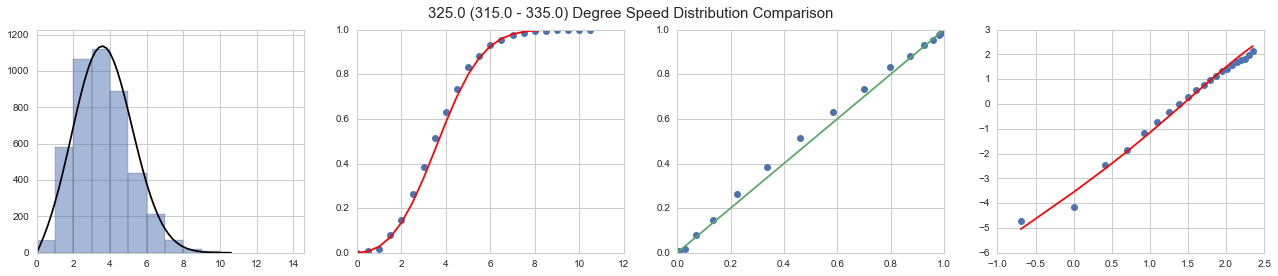

 max diff: 0.0549515598351 , speed value: 3.5 y gmm 0.459206745628

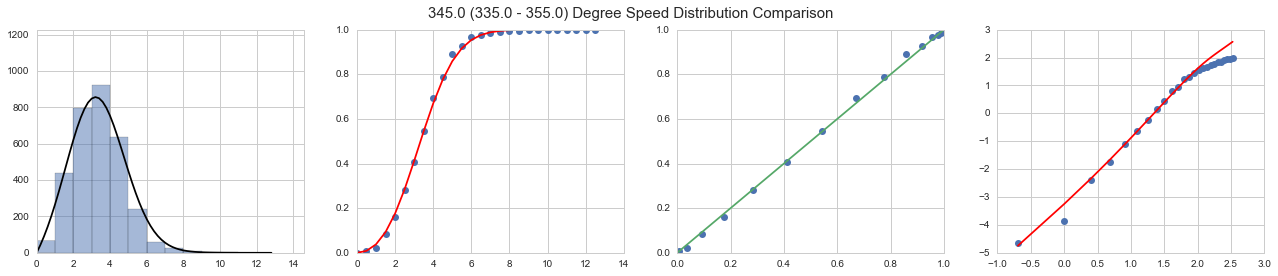

 max diff: 0.0324468252065 , speed value: 5.0 y gmm 0.858168463793


In [55]:
if len(effective_coloumn) == 16:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

## Variance over the years

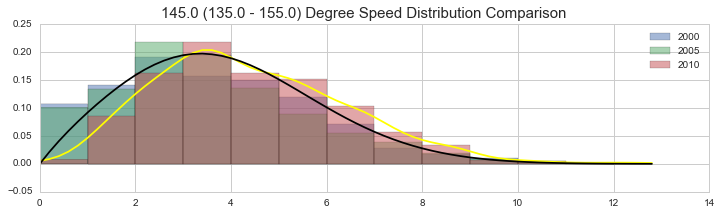

In [56]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.2)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
# y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] /0.2
plt.plot(x_vals, y_vals,'-', color='black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        df_other_years_at_angle['speed'].hist(bins=arange(0, max_speed), normed=True,
                                              alpha=0.5,figsize=(12, 3), 
                                              label = str(int(start_time/10000)))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.legend()
plt.show()

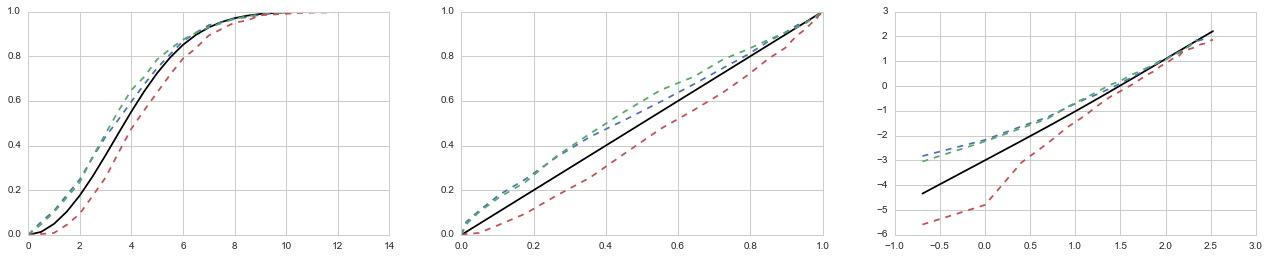

In [57]:
fig = plt.figure(figsize=(22,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,3,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax2 = fig.add_subplot(1,3,2) 
p_line = linspace(0, 1)
plt.plot(p_line, p_line,'-',color = 'black')

ax3 = fig.add_subplot(1,3,3) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        
        sample = df_other_years_at_angle.speed
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)

        ax1 = fig.add_subplot(1,3,1) 
        plt.plot(x, y_cdf,'--')

        ax2 = fig.add_subplot(1,3,2) 
        plt.plot(y_gmm, y_cdf, '--')

        ax3 = fig.add_subplot(1,3,3) 
        plt.plot(log(x), log(-log(1-y_cdf)),'--')

## Bootstrap, to see the variance of each sector

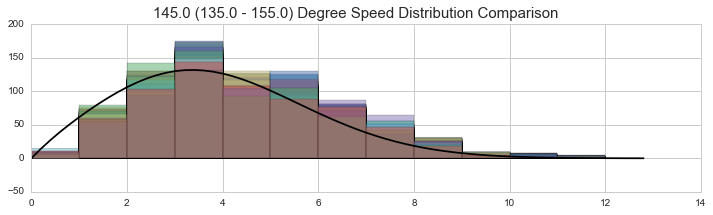

In [58]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.2)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2 * FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.095398377361 2.0 0.176236700714


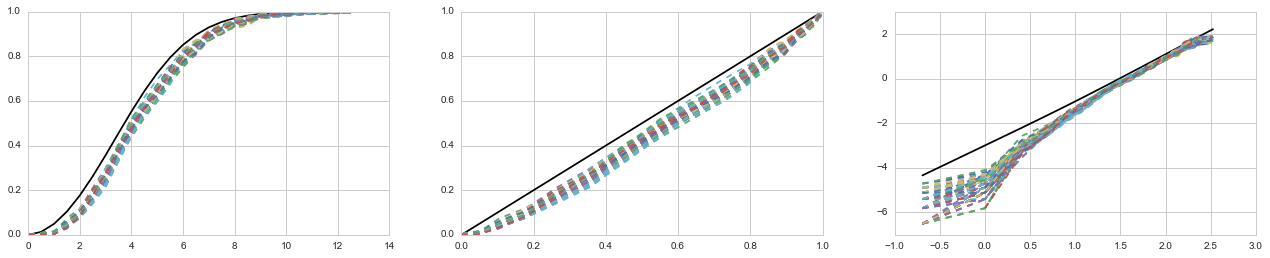

In [59]:
fig = plt.figure(figsize=(22,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,3,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax2 = fig.add_subplot(1,3,2) 
p_line = linspace(0, 1)
plt.plot(p_line, p_line,'-',color = 'black')

ax3 = fig.add_subplot(1,3,3) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,3,1) 
    plt.plot(x, y_cdf,'--')

    ax2 = fig.add_subplot(1,3,2) 
    plt.plot(y_gmm, y_cdf, '--')

    ax3 = fig.add_subplot(1,3,3) 
    plt.plot(log(x), log(-log(1-y_cdf)),'--')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# Cross Validation, to check the number of ellipse to be fitted

In [60]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error', print_result = False):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))

    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf, print_result)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [61]:
## 5-fold cross validation
CV_result_all =[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

gaussian_number_range = arange(1,6)
for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

Number of train/test dataset 30427.5 10142.5
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.127792,0.059731,0.000002,0.052935,0.625847,0.898122
gof_test,0.206353,0.063499,0.000002,0.053169,0.663225,0.886491


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.127999,0.058590,0.000002,0.052954,0.626076,0.898048
gof_test,0.154746,0.052662,0.000002,0.053116,0.607770,0.902302


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.125594,0.058586,0.000002,0.052777,0.623979,0.898729
gof_test,0.166415,0.059547,0.000002,0.056729,0.676632,0.884453


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.128423,0.060611,0.000002,0.052977,0.626352,0.897958
gof_test,0.156270,0.061927,0.000002,0.053113,0.608101,0.903488


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.062570,0.022396,5.084189e-07,0.026561,0.314031,0.974350
gof_test,0.111576,0.021536,5.645585e-07,0.028118,0.331098,0.971926


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.072370,0.026398,5.086978e-07,0.026568,0.314118,0.974336
gof_test,0.121789,0.029952,6.456794e-07,0.029685,0.354068,0.967974


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.065802,0.021758,5.087003e-07,0.026568,0.314118,0.974336
gof_test,0.110760,0.019389,6.451281e-07,0.029683,0.353377,0.967194


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.064252,0.024189,5.076951e-07,0.026542,0.313808,0.974386
gof_test,0.126178,0.027288,5.508477e-07,0.027975,0.326866,0.972016


  
Number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.083489,0.012115,4.105427e-07,0.023868,0.28219,0.979288
gof_test,0.241909,0.011225,4.759105e-07,0.026515,0.30383,0.976532


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.048909,0.023494,3.587552e-07,0.022312,0.263792,0.981900
gof_test,0.091675,0.024351,4.884369e-07,0.024365,0.307895,0.975376


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.049766,0.022712,3.611911e-07,0.022387,0.264686,0.981778
gof_test,0.086614,0.020411,4.962555e-07,0.027264,0.310087,0.974727


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.049867,0.024435,3.582042e-07,0.022295,0.263589,0.981928
gof_test,0.077971,0.026112,4.150378e-07,0.024002,0.283788,0.979071


  
Number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.613888,0.017110,2.785006e-07,0.019658,0.232421,0.985949
gof_test,0.115191,0.015687,3.460747e-07,0.021938,0.259025,0.982450


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.037799,0.014296,1.847128e-07,0.016010,0.189283,0.990681
gof_test,0.064430,0.020841,3.361661e-07,0.020815,0.255577,0.983469


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.034936,0.011906,1.855773e-07,0.016047,0.189725,0.990637
gof_test,0.071178,0.016714,3.668701e-07,0.021954,0.266447,0.982003


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.033856,0.010324,1.894152e-07,0.016212,0.191677,0.990444
gof_test,0.085959,0.017014,2.414324e-07,0.019560,0.216516,0.987412


  
Number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.100301,0.009813,1.511530e-07,0.014482,0.171226,0.992374
gof_test,0.711730,0.015036,2.968497e-07,0.018654,0.240037,0.985072


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.171733,0.011924,1.488237e-07,0.014370,0.169902,0.992492
gof_test,0.085243,0.019268,2.742346e-07,0.020566,0.230815,0.986233


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.165739,0.017255,1.476542e-07,0.014314,0.169233,0.992551
gof_test,0.238755,0.025436,2.550822e-07,0.019353,0.222514,0.987289


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.217468,0.014280,1.463533e-07,0.014251,0.168486,0.992616
gof_test,0.107295,0.013791,2.392519e-07,0.018381,0.215103,0.987896


In [62]:
for idx, gof_group in enumerate(CV_result_all):
    print 'number of gaussian', idx+1
    display(pd.DataFrame(gof_group))

number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.206353,0.063499,0.000002,0.053169,0.663225,0.886491
1,0.154746,0.052662,0.000002,0.053116,0.607770,0.902302
2,0.166415,0.059547,0.000002,0.056729,0.676632,0.884453
3,0.156270,0.061927,0.000002,0.053113,0.608101,0.903488


number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.111576,0.021536,5.645585e-07,0.028118,0.331098,0.971926
1,0.121789,0.029952,6.456794e-07,0.029685,0.354068,0.967974
2,0.110760,0.019389,6.451281e-07,0.029683,0.353377,0.967194
3,0.126178,0.027288,5.508477e-07,0.027975,0.326866,0.972016


number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.241909,0.011225,4.759105e-07,0.026515,0.303830,0.976532
1,0.091675,0.024351,4.884369e-07,0.024365,0.307895,0.975376
2,0.086614,0.020411,4.962555e-07,0.027264,0.310087,0.974727
3,0.077971,0.026112,4.150378e-07,0.024002,0.283788,0.979071


number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.115191,0.015687,3.460747e-07,0.021938,0.259025,0.982450
1,0.064430,0.020841,3.361661e-07,0.020815,0.255577,0.983469
2,0.071178,0.016714,3.668701e-07,0.021954,0.266447,0.982003
3,0.085959,0.017014,2.414324e-07,0.019560,0.216516,0.987412


number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.711730,0.015036,2.968497e-07,0.018654,0.240037,0.985072
1,0.085243,0.019268,2.742346e-07,0.020566,0.230815,0.986233
2,0.238755,0.025436,2.550822e-07,0.019353,0.222514,0.987289
3,0.107295,0.013791,2.392519e-07,0.018381,0.215103,0.987896


In [63]:
mean_gof_all = []
for idx, gof_group in enumerate(CV_result_all):
    mean_gof = np.mean(pd.DataFrame(gof_group))
    mean_gof_all.append(mean_gof)
mean_gof_all = pd.DataFrame(mean_gof_all)
mean_gof_all

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.170946,0.059409,2.109469e-06,0.054032,0.638932,0.894184
1,0.117576,0.024541,6.015534e-07,0.028865,0.341352,0.969778
2,0.124542,0.020525,4.689102e-07,0.025537,0.301400,0.976427
3,0.084189,0.017564,3.226358e-07,0.021067,0.249391,0.983834
4,0.285756,0.018383,2.663546e-07,0.019238,0.227117,0.986623


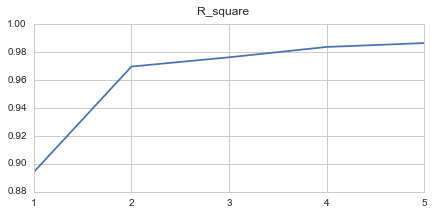

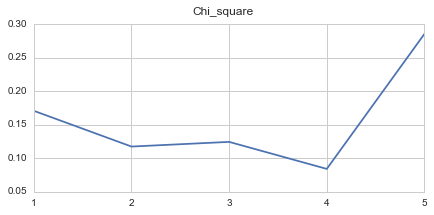

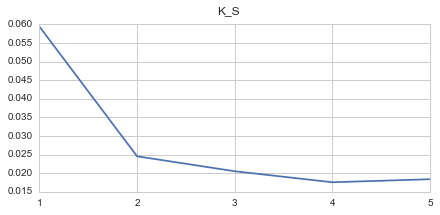

In [87]:
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 3)
    plt.plot(gaussian_number_range, mean_gof_all[column],'-')
    plt.suptitle(column)
    plt.xticks(gaussian_number_range)
    plt.show()